In [1]:
# This is my CNN based on the "labels" (really just the folder names of the classification set of images) provided.
# Sprint 1, November 10

In [13]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
from numpy.random import seed
seed(8)
import cv2
import imageio
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets, model_selection
from sklearn.metrics import confusion_matrix
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils import compute_class_weight
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, layers
from tensorflow.keras.models import  load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast, Flatten, Dense, LeakyReLU, Dropout, Softmax, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler

In [3]:
import imghdr

In [4]:
data_dir = 'data'

In [5]:
os.listdir(os.path.join(data_dir, 'Darks'))

['f0d1133b8ac216ee7f363f42d1871a1524098c7f6f2777eb31bd3faf978d1225.jpg',
 'f0d1133b8ac216ee7f363f42d1871a1524098c7f6f2777eb31bd3faf978d1225.png',
 'f0d50475c39e3e641988d711a0acf9a1d627fca847c6f5395041e4224d69ac13.nef',
 'eeb3846e9aeebffa4be2a8cb731f2a755a6653e60dcd60be257d5e64b0d32836.jpg',
 'f2300acac206294e77cf99e5a7a1a400727e0da032da7057d7f240c3e9fa6284.jpg',
 'f0d50475c39e3e641988d711a0acf9a1d627fca847c6f5395041e4224d69ac13.jpg',
 'f0d1133b8ac216ee7f363f42d1871a1524098c7f6f2777eb31bd3faf978d1225.dng',
 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.nef',
 'eff74abfe21714ec9b510d41f5eab7845e78a933263b5fa64adf09c74ffd6af2.jpg',
 'f23a87ef03fc4799be4d06eab3de199633862fd9d1f6041e601a4f32a394b864.jpg',
 'f23c776a0d321ba26094230eb19fee4d512ac8b0804e3f147deba0e466a4cc59.cr2',
 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.jpg']

In [6]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png', 'nef', 'cr2'] # figure out why all the images are not being loaded in

In [7]:
img = plt.imread(os.path.join(data_dir, 'Darks', 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.jpg'))

In [8]:
img.shape

(4928, 7380, 3)

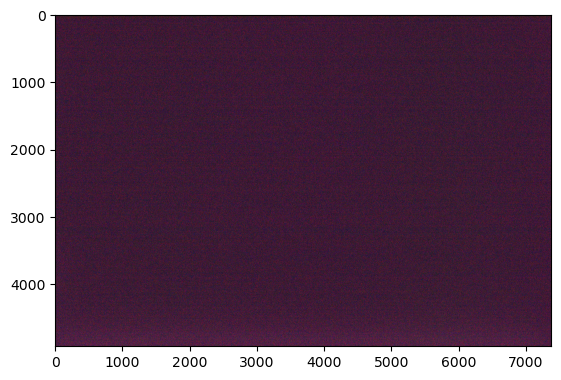

In [9]:
plt.imshow(img)

In [10]:
image_id = []
label = []
label_index = []
set_list = []

# Iterate over subfolders in data_dir
for label_idx, label_folder in enumerate(os.listdir(data_dir)):
    subfolder = os.path.join(data_dir, label_folder)
    if os.path.isdir(subfolder):
        # Iterate over images in the subfolder
        for img_file in os.listdir(subfolder):
            if img_file.endswith('.jpg') or img_file.endswith('.jpeg') or img_file.endswith('.bmp') or img_file.endswith('.png') or img_file.endswith('.nef') or img_file.endswith('.cr2'):
                # Append image_id, label, label_index, and set values to the respective lists
                image_id.append(img_file)
                label.append(label_folder)
                label_index.append(label_idx)
                set_list.append('train')
                    
# Create a dataframe using the lists
df = pd.DataFrame({'image_id': image_id, 'label': label, 'label_index': label_index, 'set': set_list})

# Add a file path column
df.loc[:, 'path'] = df.apply(lambda row: os.path.join(data_dir, row['label'], row['image_id']), axis=1)
df.head()

# Check the loaded data
print(df.head())  # Prints the first few rows of the loaded data

# Separate the features and the target variable
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

                                            image_id  \
0  6ac01773da0e961feb1e035ad47e44bccc0158356107ad...   
1  05e7d3f0f022176165169b4c169934c5abb2f315a0415e...   
2  408580dfe9cd5d872485ea70eb598a4738fc287bd1736e...   
3  5e42f642e5c2b8273eb4fffa8495a781f7b9fff539cefc...   
4  406a72805dcefa9ba8a89df3c60812e547448785304365...   

                        label  label_index    set  \
0  0to25percentPartialEclipse            0  train   
1  0to25percentPartialEclipse            0  train   
2  0to25percentPartialEclipse            0  train   
3  0to25percentPartialEclipse            0  train   
4  0to25percentPartialEclipse            0  train   

                                                path  
0  data/0to25percentPartialEclipse/6ac01773da0e96...  
1  data/0to25percentPartialEclipse/05e7d3f0f02217...  
2  data/0to25percentPartialEclipse/408580dfe9cd5d...  
3  data/0to25percentPartialEclipse/5e42f642e5c2b8...  
4  data/0to25percentPartialEclipse/406a72805dcefa...  


In [27]:
from PIL import Image

# Dataset Parameters - DO NOT CHANGE
BATCH_SIZE = 16
IMG_SIZE = (256, 256, 3)
AUTOTUNE = tf.data.AUTOTUNE

# Preprocess the image data
def preprocess_image(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    resized_image = grayscale_image.resize((256, 256))
    flattened_image = np.array(resized_image).flatten()
    normalized_image = flattened_image / 255.0
    return normalized_image

# Apply the preprocessing function to the oversampled train data
X_train_resampled_processed = np.array([preprocess_image(image_path) for image_path in X_train_resampled['path']])

# Reshape the processed data to match the input shape of the model
X_train_resampled_processed = X_train_resampled_processed.reshape((-1, 256, 256, 1))

# Convert the labels to integer indices
label_encoder = LabelEncoder()
y_train_resampled_encoded = label_encoder.fit_transform(y_train_resampled)

# Create a TensorFlow Dataset for the oversampled train data
train_dataset_resampled = tf.data.Dataset.from_tensor_slices((X_train_resampled_processed, y_train_resampled_encoded))

# Shuffle and batch the dataset
train_dataset_resampled = train_dataset_resampled.shuffle(len(X_train_resampled_processed)).batch(BATCH_SIZE)

# Preprocess the image data for the test set
X_test_processed = np.array([preprocess_image(image_path) for image_path in X_test['path']])

# Reshape the processed data to match the input shape of the model
X_test_processed = X_test_processed.reshape((-1, 256, 256, 1))

# Convert the labels to integer indices
y_test_encoded = label_encoder.transform(y_test)

# Create a TensorFlow Dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_processed, y_test_encoded))

# Shuffle and batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)


In [ ]:
for image_path in df['path'].to_numpy():
    print(image_path)

In [ ]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

In [44]:
rand_seed = 0

# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal', seed=rand_seed),
  RandomRotation(0.2, seed=rand_seed),
  RandomBrightness(0.2, seed=rand_seed),
  RandomContrast(0.2, seed=rand_seed),
])

In [77]:
# building model
model1 = Sequential()

In [78]:

input_shape = (256,256,3)
# Add model layers 
model1.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(256, 256, 1)))
model1.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=input_shape)) 
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(BatchNormalization()) 
model1.add(Conv2D(64, kernel_size=3, activation='relu')) 
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(BatchNormalization()) 
model1.add(Conv2D(128, kernel_size=3, activation='relu')) 
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(BatchNormalization()) 
model1.add(Flatten()) 
model1.add(Dense(128, activation='relu',)) 
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='softmax'))


In [79]:
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function, and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    
    # YOUR CODE HERE
    # Compile the model 
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])


    return model
    

In [117]:

# Compile model
compile_model(model1)

# Define a callback to reduce the learning rate based on the validation accuracy
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            mode = 'min',
                                            factor=0.5,
                                            min_lr=0.00001)

# Define a callback for checkpointing
checkpoint = ModelCheckpoint(filepath='checkpoints_best_only/checkpoint',
                             save_freq='epoch',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             save_best_only=True,
                             verbose=0)

# Define a callback for early stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [118]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 conv2d_32 (Conv2D)          (None, 254, 254, 128)     36992     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 127, 127, 128)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 127, 127, 128)     512       
 tchNormalization)                                               
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 62, 62, 64)      

In [82]:
initial_epochs = 50
# Train the model using the oversampled train dataset
history_resampled = model1.fit(
    train_dataset_resampled,
    epochs=initial_epochs,
    validation_data=test_dataset,
    callbacks=[lr_reduction, checkpoint])

Epoch 1/50


2023-12-12 07:57:31.296991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 2.8836 - accuracy: 0.3628

2023-12-12 07:57:35.904317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 5s 230ms/step - loss: 2.8836 - accuracy: 0.3628 - val_loss: 2.0491 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 2/50
21/21 [==============================] - 4s 192ms/step - loss: 1.7188 - accuracy: 0.5549 - val_loss: 2.2148 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 3/50
21/21 [==============================] - 4s 183ms/step - loss: 1.3859 - accuracy: 0.5884 - val_loss: 2.2716 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 4/50
21/21 [==============================] - 4s 184ms/step - loss: 1.2660 - accuracy: 0.6433 - val_loss: 2.6834 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 5/50
21/21 [==============================] - 4s 211ms/step - loss: 1.1293 - accuracy: 0.6707 - val_loss: 2.6599 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 6/50
21/21 [==============================] - 4s 188ms/step - loss: 0.9826 - accuracy: 0.7195 - val_loss: 3.1040 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 7/50
21/21 [==============================] - 4s 18

In [121]:
model2 = Sequential()

input_shape = (256,256,3)

# Add model layers
model2.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(256, 256, 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='softmax'))

compile_model(model2)

model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 batch_normalization_45 (Ba  (None, 256, 256, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 128, 128, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 126, 126, 32)      4640      
                                                                 
 batch_normalization_46 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                     

In [122]:
initial_epochs = 50
# Train the model using the oversampled train dataset
history_resampled = model2.fit(
    train_dataset_resampled,
    epochs=initial_epochs,
    validation_data=test_dataset,
    callbacks=[lr_reduction, checkpoint])

Epoch 1/50


2023-12-12 11:42:03.037926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 4.5496 - accuracy: 0.2043

2023-12-12 11:42:08.312285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 6s 165ms/step - loss: 4.5496 - accuracy: 0.2043 - val_loss: 2.0968 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 2/50
21/21 [==============================] - 1s 40ms/step - loss: 3.0590 - accuracy: 0.3567 - val_loss: 2.1726 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 3/50
21/21 [==============================] - 1s 41ms/step - loss: 2.9262 - accuracy: 0.4329 - val_loss: 2.3198 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 4/50
21/21 [==============================] - 1s 43ms/step - loss: 2.6136 - accuracy: 0.4634 - val_loss: 2.5378 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 5/50
21/21 [==============================] - 1s 40ms/step - loss: 2.1772 - accuracy: 0.4756 - val_loss: 2.7656 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 6/50
21/21 [==============================] - 1s 39ms/step - loss: 1.9174 - accuracy: 0.5396 - val_loss: 2.9977 - val_accuracy: 0.0455 - lr: 1.0000e-05
Epoch 7/50
21/21 [==============================] - 1s 40ms/st

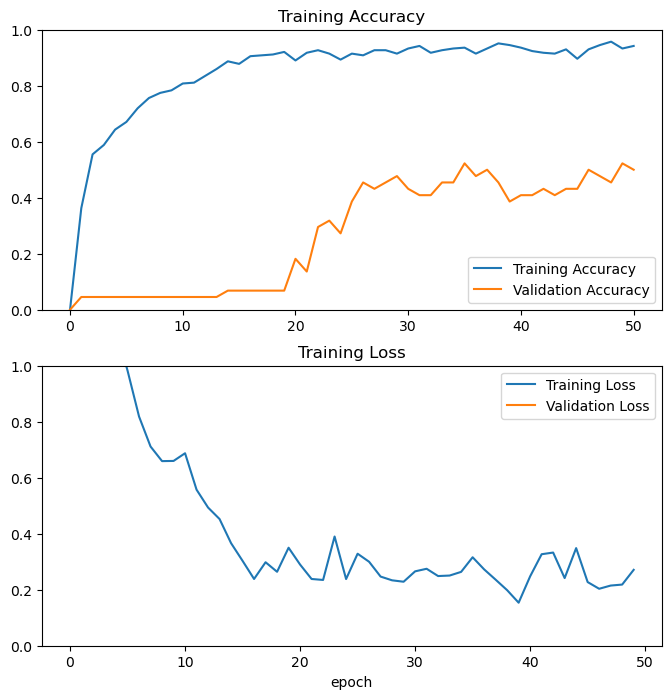

In [90]:
# Print a summary of the training accuracy and loss
acc = [0.] + history_resampled.history['accuracy']
val_acc = [0.] + history_resampled.history['val_accuracy']
loss = history_resampled.history['loss']
val_loss = history_resampled.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
"""plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')"""
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
"""plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')"""
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')

plt.show()

2/2 [==============================] - 2s 2s/step
Accuracy: 0.5
Confusion Matrix:
[[4 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [2 1 1 0 1 0 0 1]
 [0 0 0 2 0 0 0 0]
 [1 0 1 2 5 0 0 1]
 [0 0 0 0 0 2 0 0]
 [0 1 0 0 0 1 2 0]
 [2 2 0 1 1 1 1 5]]


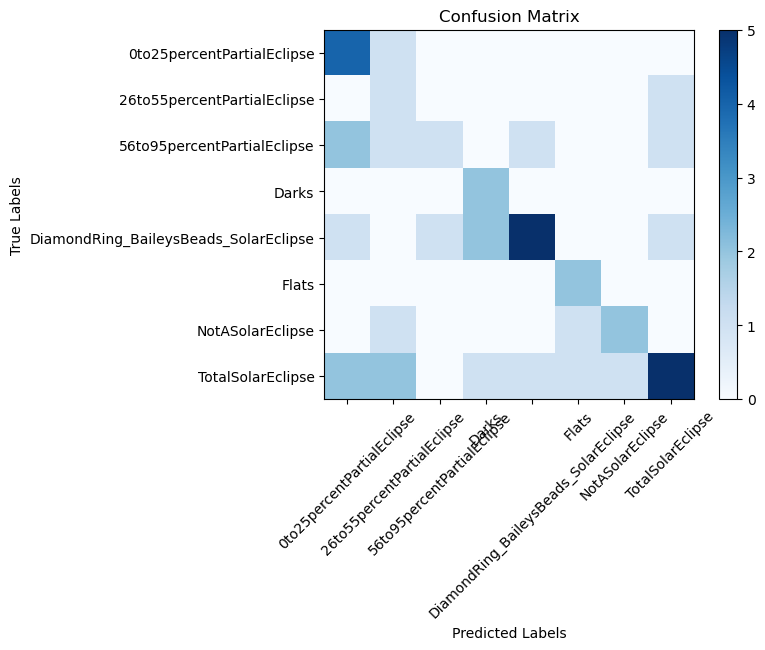

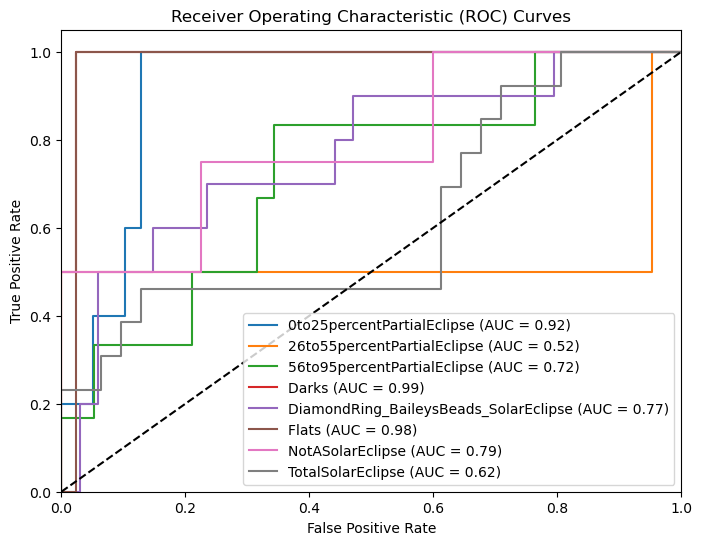

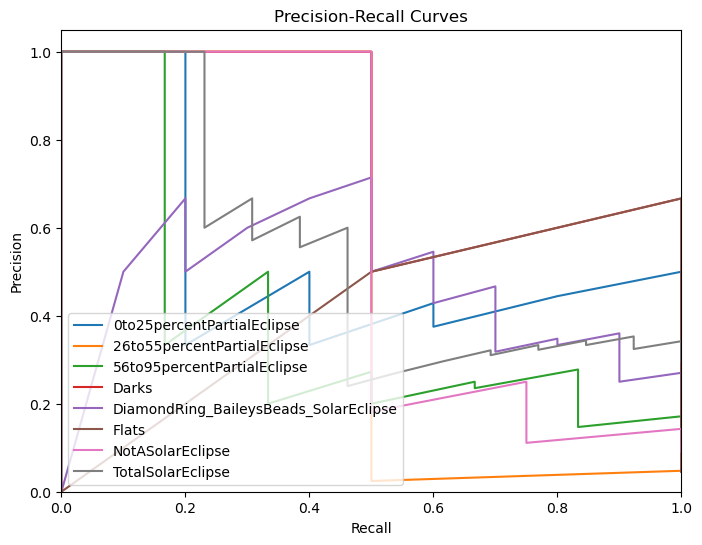

In [100]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Evaluate the model on the test dataset
y_pred = model1.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
confusion = confusion_matrix(y_test_encoded, y_pred_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

# Plot the confusion matrix
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
plt.colorbar()

# Generate ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    y_true = (y_test_encoded == i)
    y_prob = y_pred[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Generate Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    y_true = (y_test_encoded == i)
    y_prob = y_pred[:, i]
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=f'{label_encoder.classes_[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.show()

1/1 [==============================] - 0s 13ms/step


2023-12-12 08:35:51.719604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


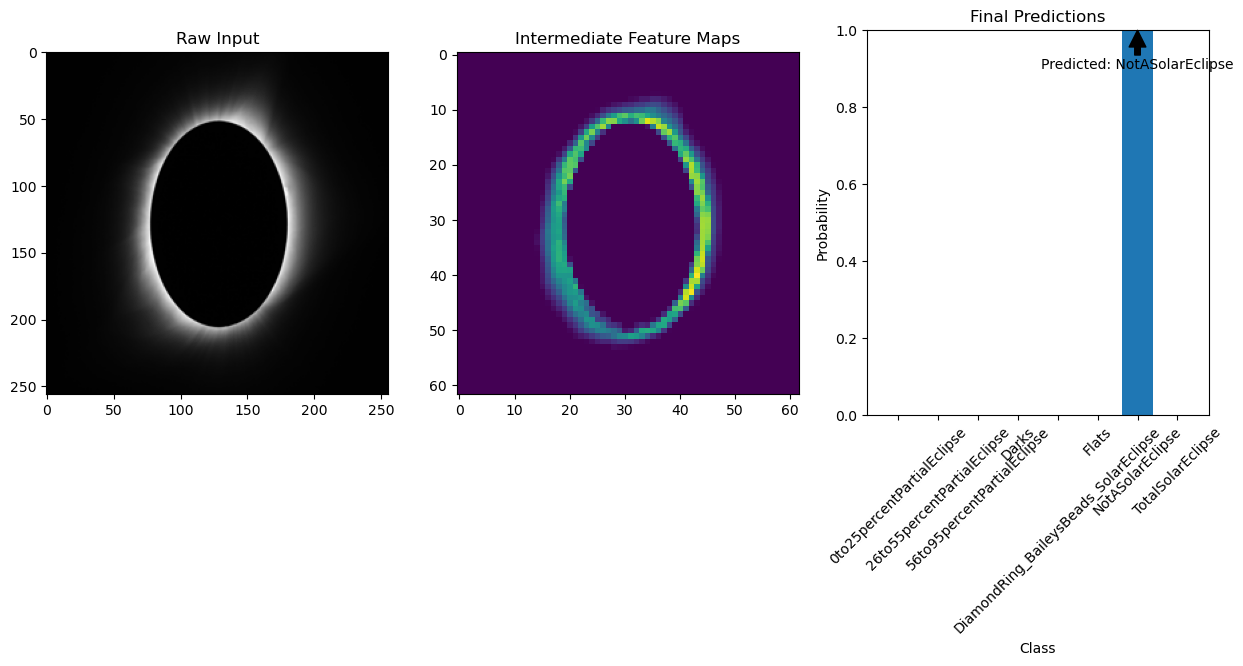

In [99]:
# Create a new model that outputs intermediate feature maps
intermediate_layer_model = tf.keras.Model(inputs=model1.input, outputs=model1.layers[6].output)

# Choose a random image from the test set
image_index = np.random.randint(low=0, high=len(X_test_processed))
chosen_image = X_test_processed[image_index]

# Reshape the image to match the input shape of the model
chosen_image_reshaped = chosen_image.reshape(1, 256, 256, 1)

# Get intermediate feature maps and final predictions
intermediate_feature_maps = intermediate_layer_model.predict(chosen_image_reshaped)
final_predictions = model1.predict(chosen_image_reshaped)
predicted_label = np.argmax(final_predictions)

# Plot the raw input, intermediate feature maps, and final predictions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(chosen_image.reshape(256, 256), cmap='gray')
axs[0].set_title('Raw Input')

axs[1].imshow(intermediate_feature_maps[0, :, :, 0], cmap='viridis')
axs[1].set_title('Intermediate Feature Maps')

axs[2].bar(range(8), final_predictions[0])
axs[2].set_xticks(range(8))
axs[2].set_xticklabels(label_encoder.classes_, rotation=45)
axs[2].set_title('Final Predictions')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Probability')
axs[2].set_ylim([0, 1])
axs[2].annotate('Predicted: ' + label_encoder.inverse_transform([predicted_label])[0], xy=(predicted_label, final_predictions[0, predicted_label]), xytext=(predicted_label, final_predictions[0, predicted_label] - 0.1), ha='center', arrowprops=dict(facecolor='black'))

plt.show()

TypeError: 'Axes' object is not subscriptable

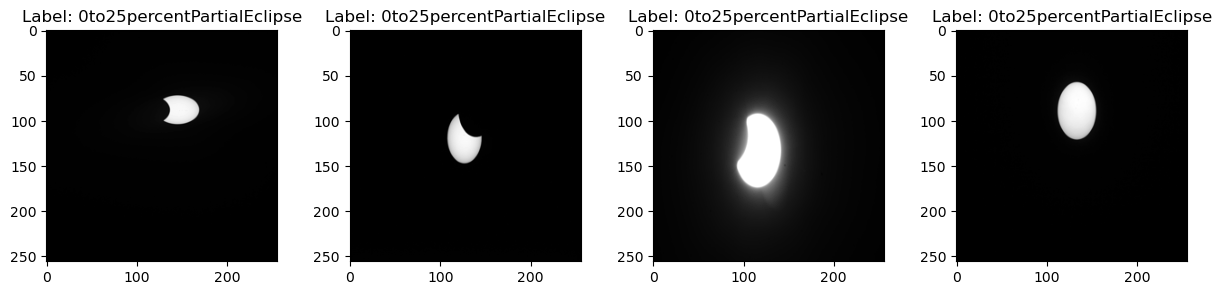

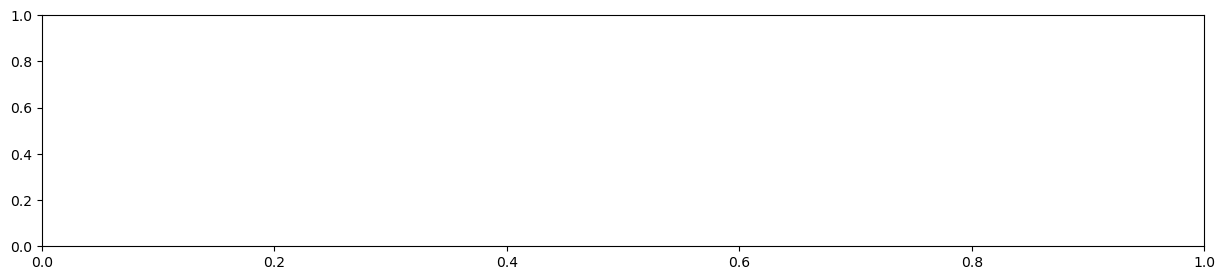

In [94]:

# Iterate over each class and display correctly classified images
for class_idx in range(8):
    class_mask = (y_pred_labels == class_idx) & (y_pred_labels == y_test_encoded)
    class_images = X_test_processed[class_mask]
    class_labels = y_test[class_mask]

    num_images = min(4, len(class_images))

    # Plot the images for the current class
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(class_images[i].reshape(256, 256), cmap='gray')
        axs[i].set_title('Label: ' + class_labels.iloc[i])


IndexError: index 1 is out of bounds for axis 0 with size 1

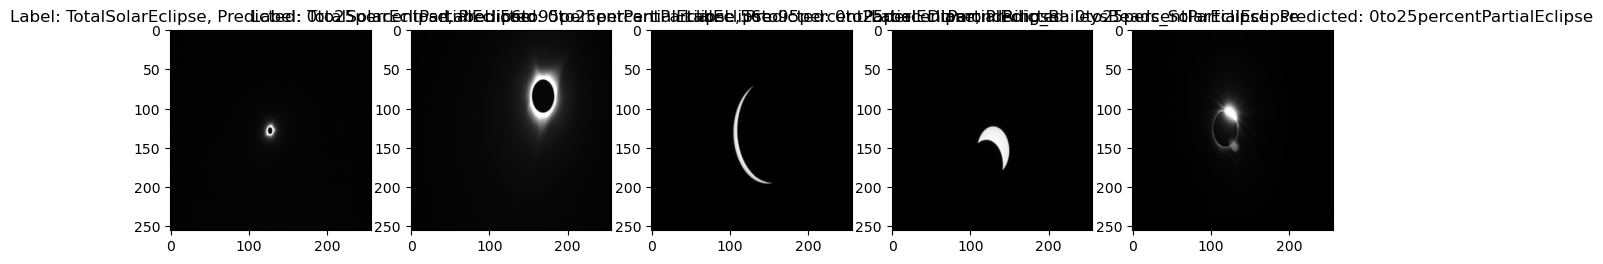

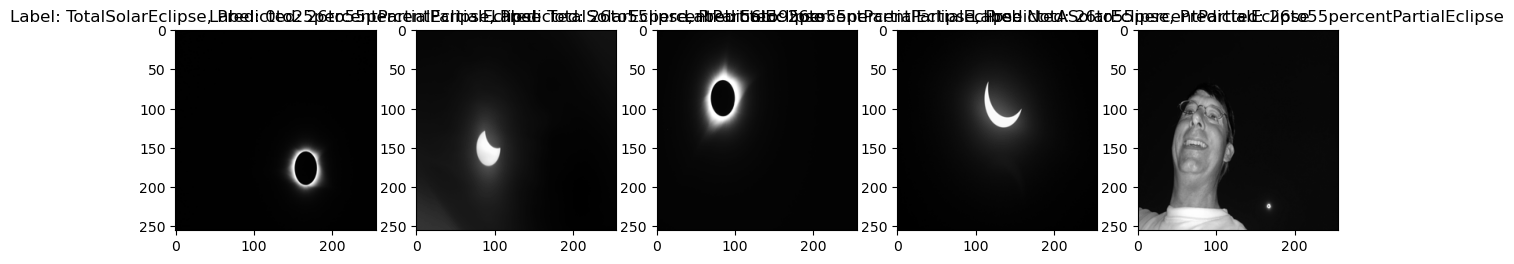

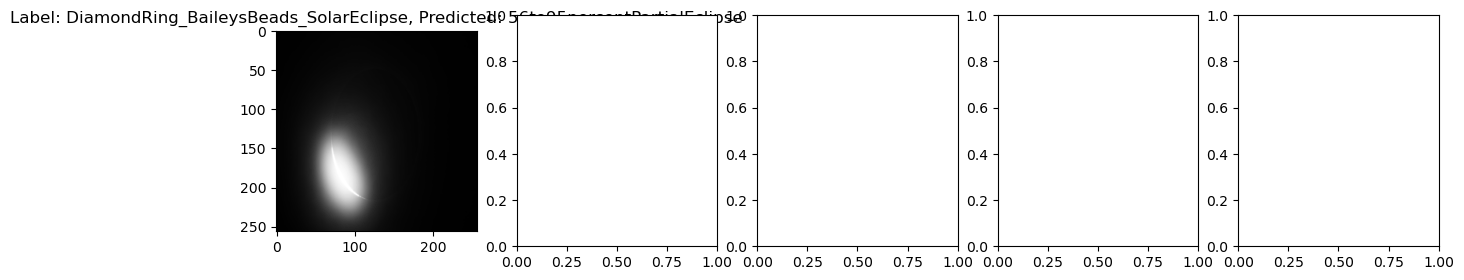

In [96]:
 # Iterate over each class and display misclassified images
for class_idx in range(8):
   class_mask = (y_pred_labels == class_idx) & (y_pred_labels != y_test_encoded)
   class_images = X_test_processed[class_mask]
   class_labels = y_test[class_mask]

   # Plot a few images for the current class
   fig, axs = plt.subplots(1, 5, figsize=(15, 3))
   for i in range(5):
       axs[i].imshow(class_images[i].reshape(256, 256), cmap='gray')
       axs[i].set_title('Label: ' + class_labels.iloc[i] + ', Predicted: ' + label_encoder.inverse_transform([y_pred_labels[class_mask][i]])[0])

In [ ]:
# SPRINT 2
# Fix issue with cr2 and nef file types not being loaded
# Implement solutions to overfitting (regularization, preprocessing tactics, data augmentation)